In [5]:
import os
import json
import gzip
import shutil
import torch
import numpy as np
import matplotlib.pyplot as plt

from karhu.utils_input import *
from karhu.models import CNN_gmax, load_model


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
model_dir = "../model/jet_2H/"
model, scaling_params = load_model(model_dir)

n_profile_points = 64
x_1 = np.linspace(1e-5, 1, n_profile_points) ** (1 / 4)
theta = np.linspace(1e-5, np.pi, 2*n_profile_points)

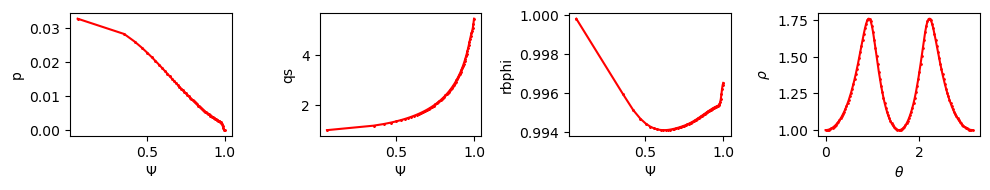

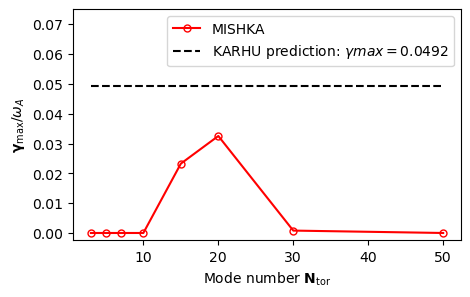

In [19]:
"""
The data directory in the example folder contains the HELENA files needed to construct the model input.
You can replace this with your own HELENA equilibrium files. The model predicts the maximum growth rate of
the given equilibrium.
The reference values are the mode number (Ntor) specific growth rates calculated by MISHKA for the same equilibrium.
"""
from karhu.utils_helena import load_from_helena
rundir = "./data/jet_2H/"

with gzip.open(os.path.join(rundir, 'fort.12.gz'), 'rb') as f_in:
    with open(os.path.join(rundir, 'fort.12'), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

x = load_from_helena(rundir)

# Plot the equilibrium profiles
fig_x, axs = plt.subplots(1, 4, figsize=(10, 2))
for i, label in enumerate(['p', 'qs', 'rbphi']):
    axs[i].plot(x_1, x[i].flatten(), ".-", c="red", markersize=2, fillstyle="top")
    axs[i].set_xlabel(r"$\Psi$")
    axs[i].set_ylabel(label)
axs[3].plot(theta, x[3].flatten(), ".-", c="red", markersize=2, fillstyle="full")
axs[3].set_xlabel(r"$\theta$")
axs[3].set_ylabel(r"$\rho$")
plt.tight_layout()
plt.show()

x = scale_model_input(x, scaling_params)
y_pred = model(*x)
y_pred = descale_minmax(
    y_pred.item(),
    scaling_params["growthrate"][0],
    scaling_params["growthrate"][1],
)
y_pred = 0.0 if y_pred <= 0.0 else y_pred

y_true = [0.0, 0.0, 0.0, 0.0, np.sqrt(0.5405E-03), np.sqrt(0.1058E-02), 0.8027E-03, 0.0]
x_true = [3, 5, 7, 10, 15, 20, 30, 50,]

fig_prediction, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(x_true, y_true, ".-", c="red", markersize=10, fillstyle="none", label="MISHKA",)
plt.hlines(y=y_pred, xmin=3, xmax=50, colors='black', linestyles='dashed', label=f'KARHU prediction: $\gamma max = ${y_pred:.4f}')
plt.xlabel(r"Mode number $\mathbf{N_{\text{tor}}}$")
plt.ylabel(r"$\mathbf{\gamma_{\text{max}}}/\omega_A$")
plt.ylim(None, 0.075)
plt.legend()
plt.show()
